# Purpose

The purpose of this workbook is to create a linear regression based on songs extracted and scraped from the Billboard top 100 chart from April 2012 to April 2019 and audio features for these songs pulled from the Spotify API. To do this, I will first import all of the libraries that I will be using for my analysis. 

In [1]:
%pylab inline

import pandas as pd
import numpy as np 
import seaborn as sns
sns.set_palette('pastel')
sns.set_style('whitegrid')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error

import statsmodels.api as sm
import statsmodels.formula.api as smf

Populating the interactive namespace from numpy and matplotlib


Next I will load in the csv file that contains all of my cleaned Billboard and Spotify information with the additional features that I engineered in my previous notebook. 

In [2]:
# Load in data
df = pd.read_csv('final_clean.csv', index_col=False)
df.head()

week_of  rank                                          title  \
0  2014-04-05    16                                        #SELFIE   
1  2013-05-11    17                                     #thatPOWER   
2  2012-08-18    34                        (Kissed You) Good Night   
3  2019-01-05    32  (There's No Place Like) Home For The Holidays   
4  2017-09-23     4                               ...Ready For It?   

                             artist  year  danceability  energy   key  \
0              ['The Chainsmokers']  2014         0.807   0.916   0.0   
1  ['will.i.am ', ' Justin Bieber']  2013         0.797   0.608   6.0   
2                      ['Gloriana']  2012         0.523   0.747  11.0   
3                    ['Perry Como']  2019         0.541   0.441   5.0   
4                  ['Taylor Swift']  2017         0.613   0.764   2.0   

   loudness  mode      ...        time_signature       main_artist  \
0    -3.282   1.0      ...                   4.0  The Chainsmokers   
1    -6.096   0.0      ...                   4.0         will.i.am   
2    -6.125   1.0      ...                   4.0          Gloriana   
3    -9.692   1.0      ...                   4.0        Perry Como   
4    -6.509   1.0      ...                   4.0      Taylor Swift   

   total_songs_on_chart  average_rank  total_weeks_on_chart  prev_rank  \
0                    15     42.545455                  12.0        0.0   
1                     6     43.062500                  17.0       58.0   
2                     2     58.050000                  21.0        0.0   
3                     1     36.500000                   3.0        0.0   
4                    33     41.736842                  21.0        1.0   

   prev_twoc  prev_total_songs avg_prev_rank  avg_prev_twoc  
0        0.0                 1           0.0            0.0  
1        1.0                 3          58.0            1.0  
2        0.0                 1           0.0            0.0  
3        0.0                 1           0.0            0.0  
4       21.0                27           1.0           21.0  

[5 rows x 27 columns]

Let's take a look at the correlations and see if there is any evidence of multicollinearity.

In [3]:
df.corr()

rank      year  danceability    energy       key  \
rank                  1.000000  0.042496     -0.045932  0.007714 -0.001708   
year                  0.042496  1.000000      0.183113 -0.248119  0.027411   
danceability         -0.045932  0.183113      1.000000 -0.105406  0.014357   
energy                0.007714 -0.248119     -0.105406  1.000000  0.038848   
key                  -0.001708  0.027411      0.014357  0.038848  1.000000   
loudness             -0.036330 -0.179302     -0.034204  0.752958  0.037873   
mode                 -0.008325 -0.050158     -0.109686  0.025853 -0.170301   
speechiness           0.053234  0.204787      0.271275 -0.125472  0.034255   
acousticness          0.045310  0.157679     -0.143859 -0.527661  0.004984   
instrumentalness      0.014934  0.008469     -0.000834 -0.058466 -0.023350   
liveness              0.021260 -0.070397     -0.052979  0.152756  0.005678   
valence              -0.036363 -0.121066      0.180045  0.465163  0.051248   
tempo                 0.010092 -0.013594     -0.107185  0.134017 -0.000878   
duration_ms          -0.041998 -0.250332     -0.161184 -0.021996 -0.031097   
time_signature       -0.020244 -0.012246      0.131798  0.114275 -0.006568   
total_songs_on_chart -0.057911  0.079724      0.162452 -0.227185 -0.006905   
average_rank          0.925047  0.042300     -0.058605  0.034880 -0.004309   
total_weeks_on_chart -0.703304 -0.222090     -0.017704  0.081485  0.006889   
prev_rank             0.147271  0.200296      0.052971 -0.072149  0.019583   
prev_twoc            -0.108988 -0.045251     -0.068937  0.076847  0.014243   
prev_total_songs     -0.088254  0.300980      0.119190 -0.211317 -0.010624   
avg_prev_rank         0.146276  0.227335      0.072117 -0.104719  0.009546   
avg_prev_twoc        -0.125036  0.050082     -0.073295  0.059990  0.013826   

                      loudness      mode  speechiness  acousticness  \
rank                 -0.036330 -0.008325     0.053234      0.045310   
year                 -0.179302 -0.050158     0.204787      0.157679   
danceability         -0.034204 -0.109686     0.271275     -0.143859   
energy                0.752958  0.025853    -0.125472     -0.527661   
key                   0.037873 -0.170301     0.034255      0.004984   
loudness              1.000000 -0.000614    -0.161157     -0.442877   
mode                 -0.000614  1.000000    -0.121090      0.021703   
speechiness          -0.161157 -0.121090     1.000000      0.006458   
acousticness         -0.442877  0.021703     0.006458      1.000000   
instrumentalness     -0.118529 -0.059187    -0.053926      0.070954   
liveness              0.086049 -0.025605     0.088108     -0.089452   
valence               0.335005  0.024685    -0.058309     -0.156249   
tempo                 0.098557  0.011054     0.120643     -0.093066   
duration_ms          -0.045564 -0.009047    -0.023109      0.005832   
time_signature        0.072834 -0.027651     0.043766     -0.109894   
total_songs_on_chart -0.207419 -0.078283     0.348783      0.010342   
average_rank         -0.006703  0.022371     0.044562      0.016797   
total_weeks_on_chart  0.120359  0.064832    -0.172447     -0.084752   
prev_rank            -0.047040 -0.025161     0.093655      0.016869   
prev_twoc             0.076558  0.014937    -0.069971     -0.044334   
prev_total_songs     -0.197665 -0.039483     0.244537      0.045422   
avg_prev_rank        -0.076486 -0.008943     0.153532      0.031983   
avg_prev_twoc         0.079884 -0.030319    -0.076504     -0.026644   

                      instrumentalness      ...        duration_ms  \
rank                          0.014934      ...          -0.041998   
year                          0.008469      ...          -0.250332   
danceability                 -0.000834      ...          -0.161184   
energy                       -0.058466      ...          -0.021996   
key                          -0.023350      ...          -0.031097   
loudness                    

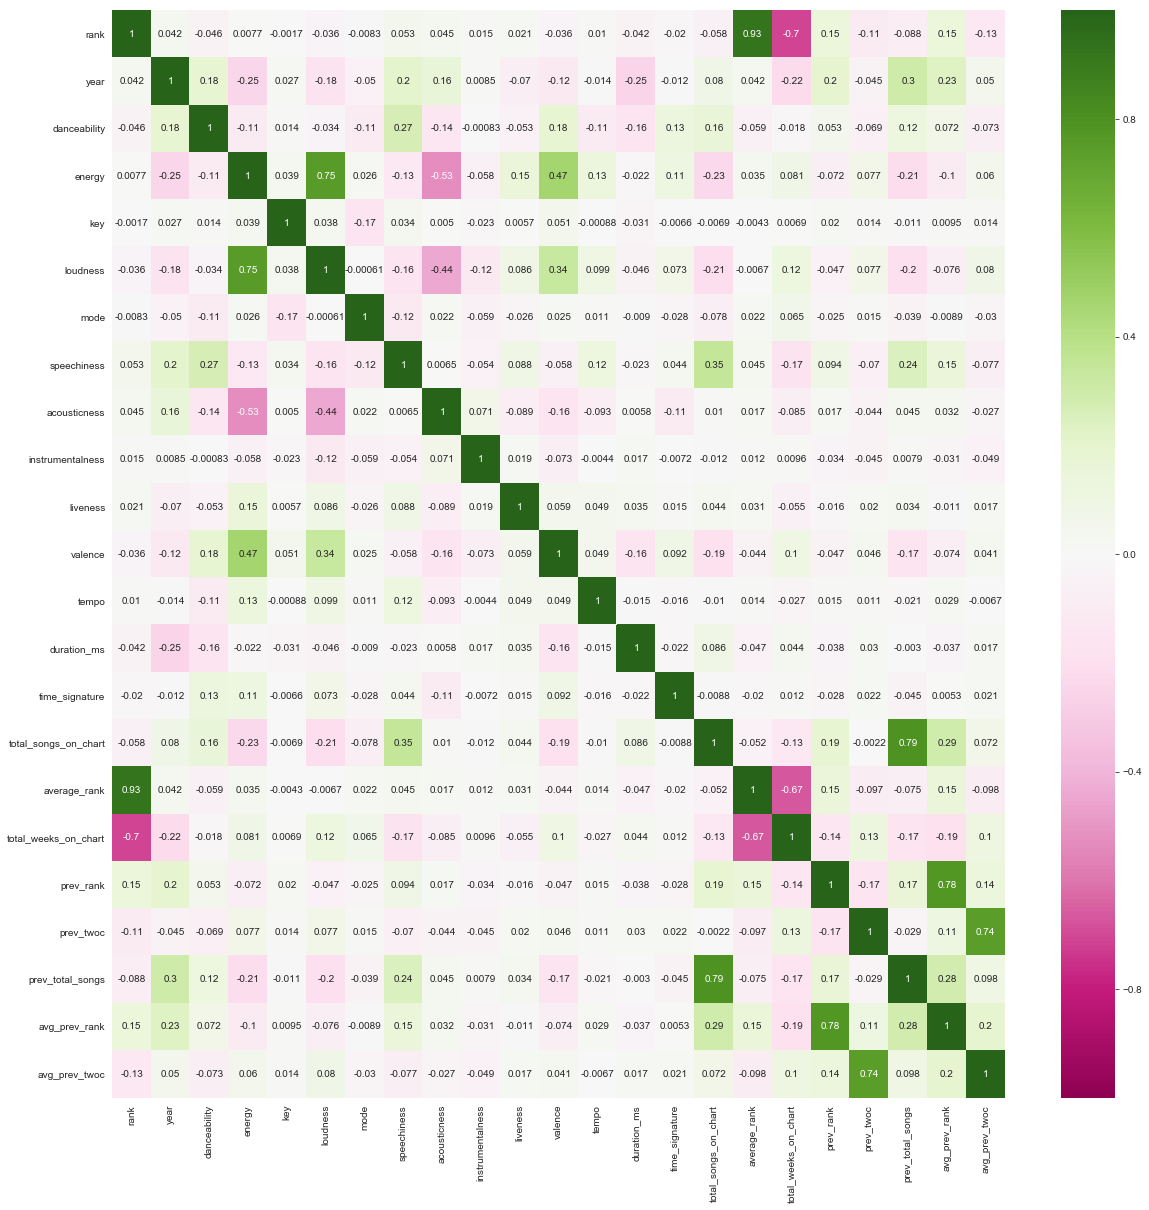

In [28]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), cmap='PiYG', annot=True, vmin=-1, vmax=1);
plt.savefig("corr.png")

#### One thing to note about the correlations

Because a lower rank is better in this case, a negative correlation means that as the rank goes down (which is a good thing), the feature goes up and vice versa. For a positive correlation, as the rank goes up (which is a bad thing) the feature goes up and vice versa.

Another interesting insight we get from this correlation plot is how year is negatively correlated to duration, meaning songs are getting shorter as the years increases, which directly supports many reports that songs are getting shorter and shorter due to streaming services and their payout system. Additionally, the energy of songs are also decreasing, but acousticness and danceability are increasing. 

Looking at our correlations, we can automatically delete the average rank as this might cause multicollinearity as they are too related. As such, let's create a smaller df without that column while also labelling our features and target variables.

Before doing that, let's make a pairplot so we can see how are features are distributed.

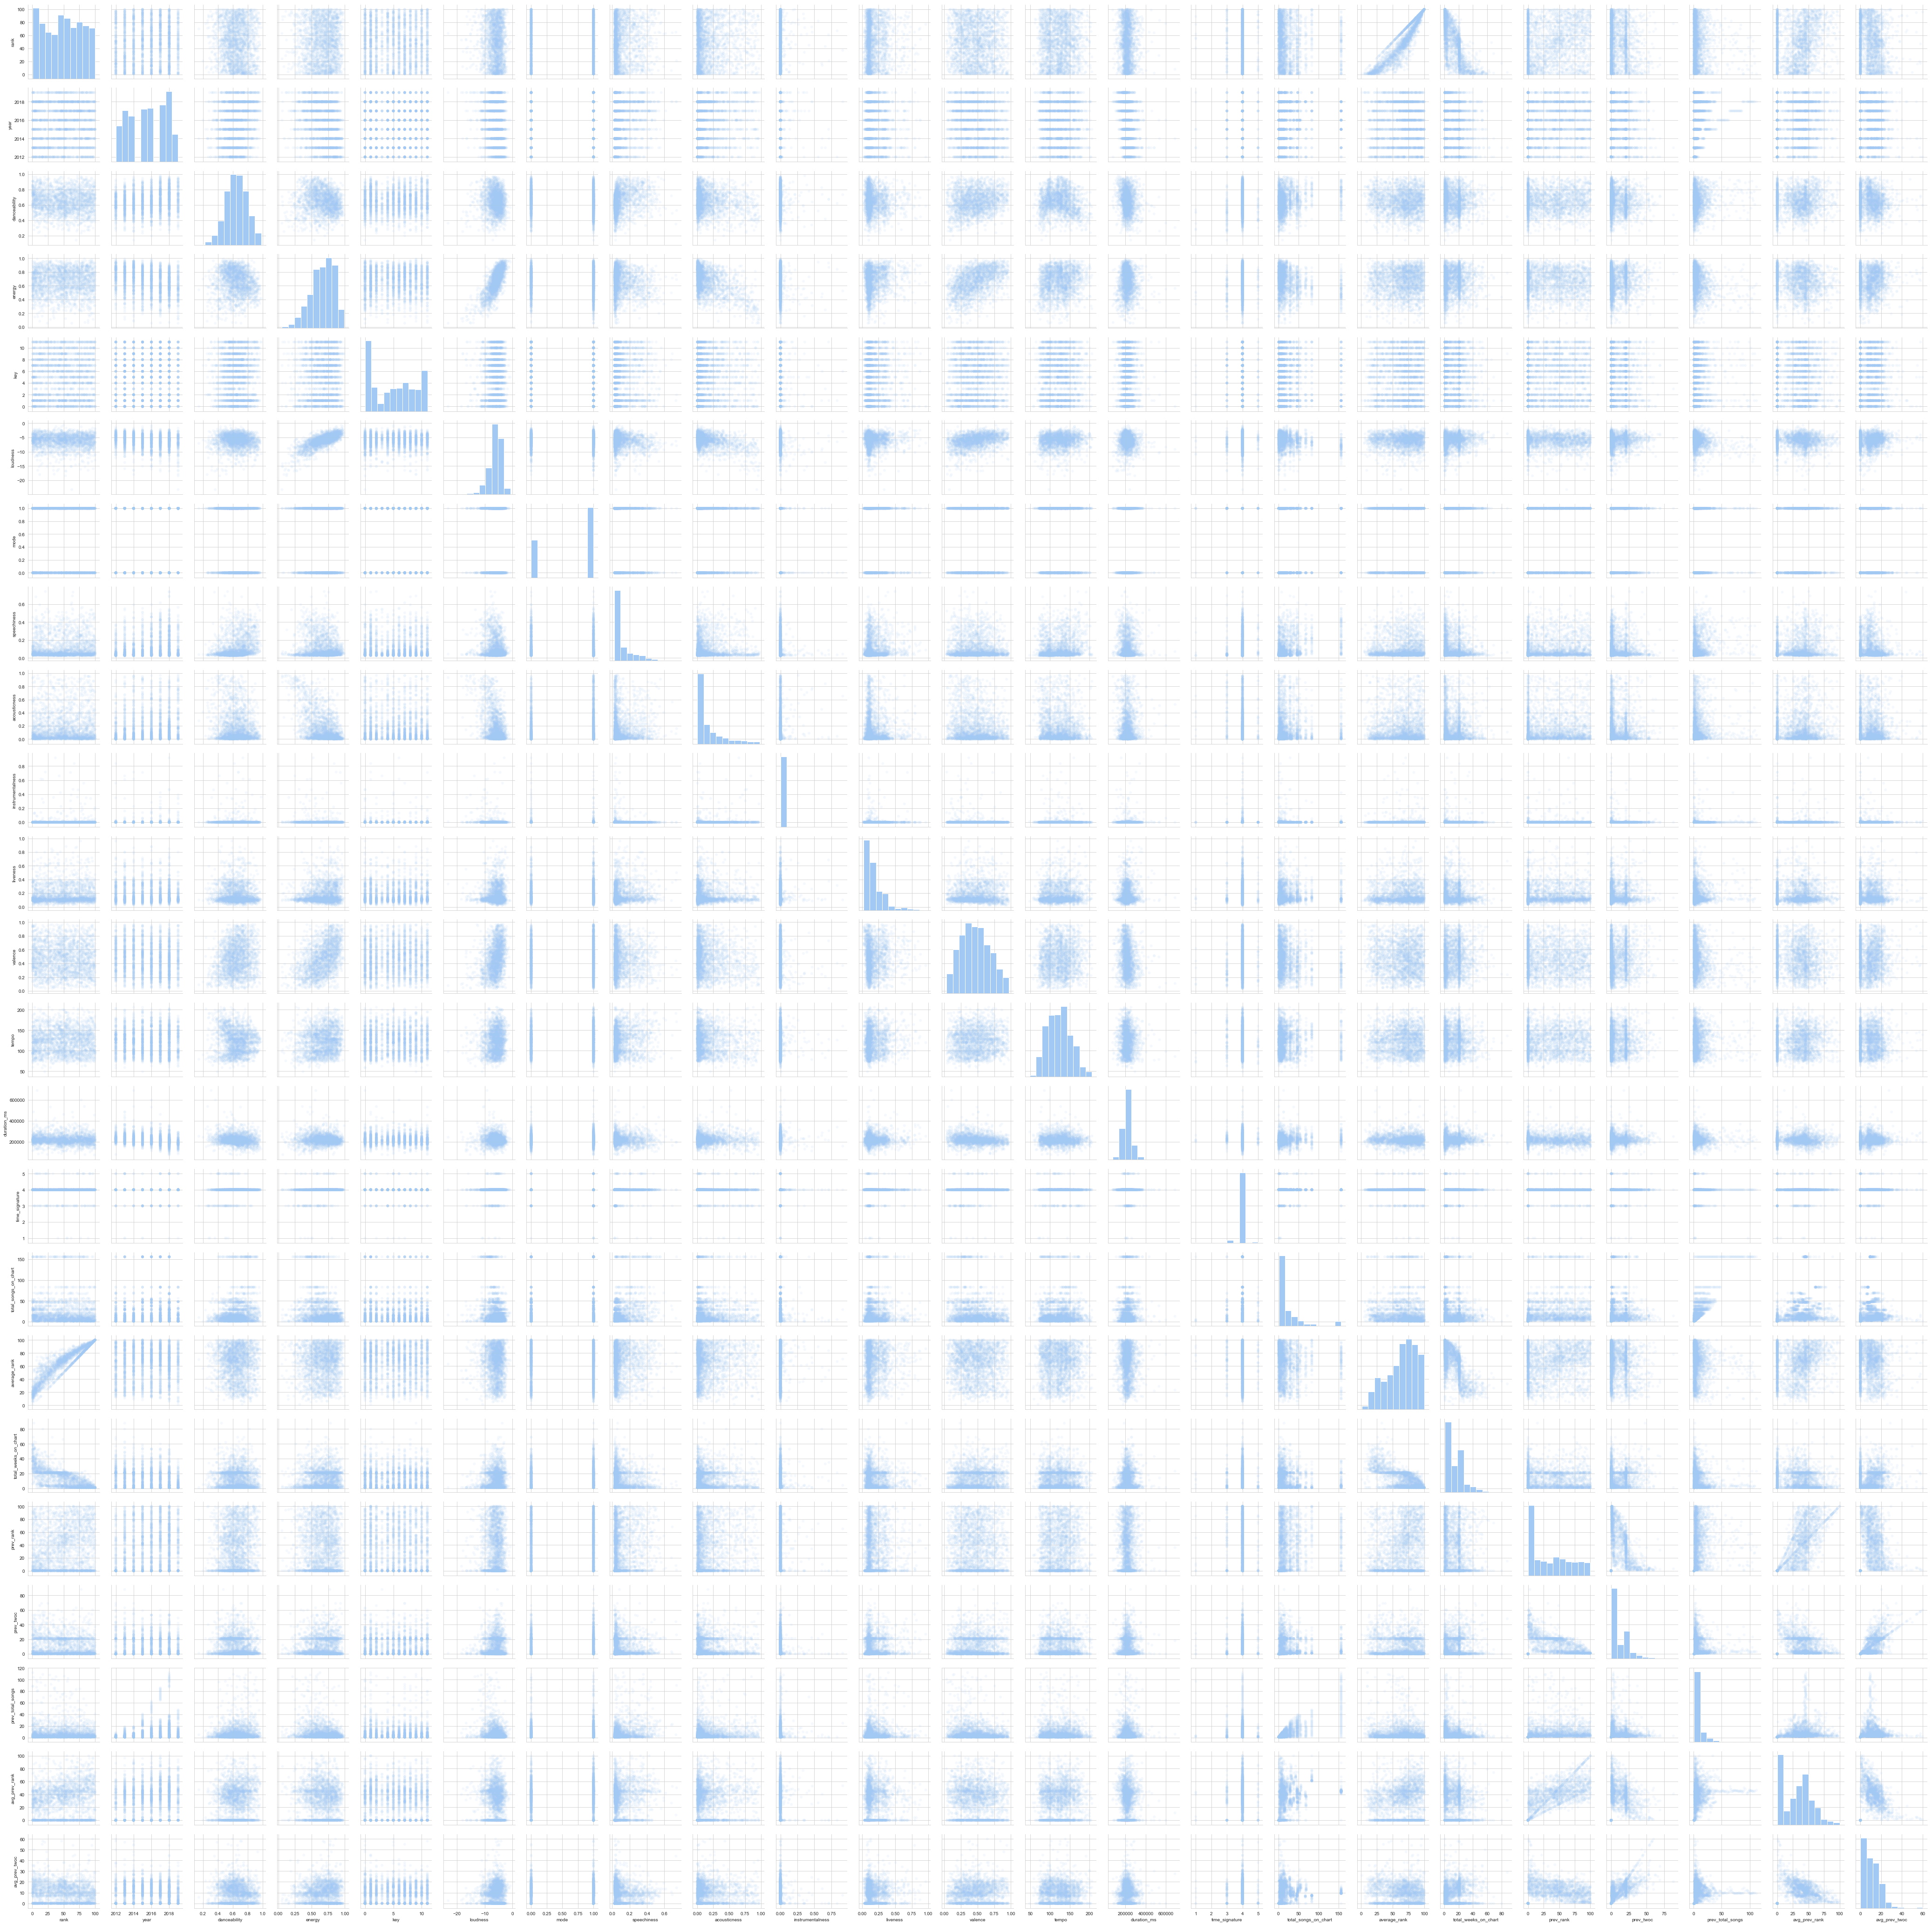

In [5]:
sns.pairplot(df, plot_kws=dict(alpha=0.1, edgecolor='none'))

In [6]:
df.columns

Index(['week_of', 'rank', 'title', 'artist', 'year', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature', 'main_artist', 'total_songs_on_chart', 'average_rank',
       'total_weeks_on_chart', 'prev_rank', 'prev_twoc', 'prev_total_songs',
       'avg_prev_rank', 'avg_prev_twoc'],
      dtype='object')

# Linear Regression

Before getting into the actual modelling, I will assign variables to the features I will be using.

In [3]:
X = df.loc[:,['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness'
              ,'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms'
              ,'time_signature', 'total_songs_on_chart','total_weeks_on_chart', 'prev_rank'
              , 'prev_twoc', 'prev_total_songs','avg_prev_rank','avg_prev_twoc']]

y = df['rank']

## Step 1: Initial Modelling 

I'll first try with a simple linear regression with scikit learn and all of my features, without any scaling.

In [4]:
lr = LinearRegression()

lr.fit(X, y)

print('R^2 score:', lr.score(X, y), '\n')
print('Coefficients:', lr.coef_, '\n')
print('Intercept:', lr.intercept_)

R^2 score: 0.5546282570648973 

Coefficients: [-8.28481651e+00  6.60458920e+00  3.08758865e-02 -9.47194876e-02
  1.59991457e+00 -5.26765047e+00 -3.97542498e-01  1.63151583e+01
 -3.34528897e+00  7.16863937e-01 -2.40603982e-02 -1.05084942e-05
 -1.84026771e+00  4.48232743e-02 -1.72532833e+00  9.65391595e-02
  1.47483599e-01 -5.05246524e-01  2.38914409e-04 -3.25592793e-01] 

Intercept: 87.64754960536223


R<sup>2</sup> looks sort of promising. Now let's test, train, split our data as well as scale it as a lot of our features are right skewed.

## Step 2: Test, Train, Split, Validate and Scaling

Because my data is right skewed, I will standardize the data so that all the features are on the same scale. This is also necessary when using regularization.  This scaling is part of our model that we will use below, so we need to scale using the training set feature distributions and apply the same scaling to the validation and test without refitting the scaler. 

In [5]:
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=8)

## Step 3: Modelling - Regular Linear Regression vs Ridge/Lasso vs Polynomial Ridge/Lasso Cross Validation 

I will try three different models with our test, train, validation data. 

In [6]:
#set up the 3 models we're choosing from:

lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

lm_reg = RidgeCV(cv=5)
lm_reg_lasso = LassoCV(cv=5)

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train_scaled)
X_val_poly = poly.transform(X_val_scaled)
X_test_poly = poly.transform(X_test_scaled)

lm_poly = RidgeCV(cv=5)
lm_poly_lasso = LassoCV(cv=5)

First, I will run a regular linear regression, a ridge regression, and degree 2 polynomial regression with ridge cross validation. 

In [7]:
#validate

lm.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.6f}')

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.6f}')

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.6f}')

Linear Regression val R^2: 0.535356
Ridge Regression val R^2: 0.535319
Degree 2 polynomial regression val R^2: 0.572094


/Users/amyksu/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Next, I will run a lasso regression and degree 2 polynomial regression with lasso cross validation.

In [8]:
#validate

reg_lasso = lm_reg_lasso.fit(X_train_scaled, y_train)
print(f'Lasso Regression val R^2: {lm_reg_lasso.score(X_val_scaled, y_val):.6f}')

poly_lasso = lm_poly_lasso.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression with lasso regularization val R^2: {lm_poly_lasso.score(X_val_poly, y_val):.6f}')

Lasso Regression val R^2: 0.533515
Degree 2 polynomial regression with lasso regularization val R^2: 0.624191


Using our polynomial regression and lasso regularization, I got a .624191 R<sup>2</sup> value, which is pretty good. Let's take a look at our coefficients.

In [9]:
lm_poly_lasso.coef_

array([ 0.00000000e+00, -1.24743004e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -2.57739654e-01,
        1.69792159e-01, -0.00000000e+00, -5.88405818e+00, -2.59004056e+01,
        4.55003730e+00,  2.47681590e+00, -4.86072595e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.29098564e-01,  7.25775617e-01,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -5.41301162e-01, -0.00000000e+00, -1.13043481e+00, -0.00000000e+00,
        0.00000000e+00,  3.96000873e-01,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -6.12872885e-02, -0.00000000e+00,  0.00000000e+00,
       -1.07888499e-01,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  4.44513789e-01,  0.00000000e+00,
        0.00000000e+00,  2.28018919e-02, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -

In [14]:
poly.get_feature_names(X_train.columns)

['1',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration_ms',
 'time_signature',
 'total_songs_on_chart',
 'total_weeks_on_chart',
 'prev_rank',
 'prev_twoc',
 'prev_total_songs',
 'avg_prev_rank',
 'avg_prev_twoc',
 'danceability^2',
 'danceability energy',
 'danceability key',
 'danceability loudness',
 'danceability mode',
 'danceability speechiness',
 'danceability acousticness',
 'danceability instrumentalness',
 'danceability liveness',
 'danceability valence',
 'danceability tempo',
 'danceability duration_ms',
 'danceability time_signature',
 'danceability total_songs_on_chart',
 'danceability total_weeks_on_chart',
 'danceability prev_rank',
 'danceability prev_twoc',
 'danceability prev_total_songs',
 'danceability avg_prev_rank',
 'danceability avg_prev_twoc',
 'energy^2',
 'energy key',
 'energy loudness',
 'energy mode',
 'energy speechiness',
 'energy acousticness',


There are a lot of zeroes and a lot of features but we can't tell which features were helpful in our regression. I'll fix this by creating a dataframe with the coefficients and their feature names.

In [10]:
# show only the important features 
feature_coef = pd.DataFrame({'feature_names': poly.get_feature_names(X_train.columns),'coefficients':lm_poly_lasso.coef_}).sort_values('coefficients', ascending=False)
feature_coef

feature_names  coefficients
16                               prev_rank      4.550037
210                 total_weeks_on_chart^2      3.403510
229            avg_prev_rank avg_prev_twoc      2.939123
17                               prev_twoc      2.476816
228                        avg_prev_rank^2      2.468168
203                 total_songs_on_chart^2      2.250732
217                    prev_rank prev_twoc      1.835509
173               valence prev_total_songs      1.027693
61                            key loudness      0.906543
208     total_songs_on_chart avg_prev_rank      0.734297
23                        danceability key      0.725776
205         total_songs_on_chart prev_rank      0.703797
213  total_weeks_on_chart prev_total_songs      0.543139
175                  valence avg_prev_twoc      0.499517
84                        loudness valence      0.486940
224                prev_twoc avg_prev_twoc      0.463845
230                        avg_prev_twoc^2      0.459619
46                     energy acousticness      0.444514
189       duration_ms total_weeks_on_chart      0.408611
33             danceability time_signature      0.396001
164                 liveness avg_prev_twoc      0.346605
134      acousticness total_weeks_on_chart      0.228919
106                         mode prev_rank      0.223862
130                     acousticness tempo      0.212775
144           instrumentalness duration_ms      0.191397
102                       mode duration_ms      0.189007
12                             duration_ms      0.169792
104              mode total_songs_on_chart      0.162918
181                        tempo prev_rank      0.149746
68                               key tempo      0.139565
..                                     ...           ...
40              danceability avg_prev_twoc     -0.107888
119       speechiness total_songs_on_chart     -0.115494
22                     danceability energy     -0.129099
96                        mode speechiness     -0.137808
97                       mode acousticness     -0.139647
53             energy total_songs_on_chart     -0.182204
186                          duration_ms^2     -0.198564
69                         key duration_ms     -0.233457
196    time_signature total_songs_on_chart     -0.247316
11                                   tempo     -0.257740
118             speechiness time_signature     -0.268936
88           loudness total_songs_on_chart     -0.299247
211         total_weeks_on_chart prev_rank     -0.309813
123           speechiness prev_total_songs     -0.336918
111                          speechiness^2     -0.381561
194              duration_ms avg_prev_twoc     -0.399551
191                  duration_ms prev_twoc     -0.466676
28           danceability instrumentalness     -0.541301
78                              loudness^2     -0.559063
89           loudness total_weeks_on_chart     -0.591646
128                  acousticness liveness     -0.633943
129                   acousticness valence     -0.671755
91                      loudness prev_twoc     -0.890491
114                   speechiness liveness     -1.002270
30                    danceability valence     -1.130435
193              duration_ms avg_prev_rank     -1.149649
1                             danceability     -1.247430
18                        prev_total_songs     -4.860726
14                    total_songs_on_chart     -5.884058
15                    total_weeks_on_chart    -25.900406

[231 rows x 2 columns]

In [11]:
imp_coef = pd.concat([feature_coef.head(8),
                     feature_coef.tail(3)])

imp_coef

feature_names  coefficients
16                     prev_rank      4.550037
210       total_weeks_on_chart^2      3.403510
229  avg_prev_rank avg_prev_twoc      2.939123
17                     prev_twoc      2.476816
228              avg_prev_rank^2      2.468168
203       total_songs_on_chart^2      2.250732
217          prev_rank prev_twoc      1.835509
173     valence prev_total_songs      1.027693
18              prev_total_songs     -4.860726
14          total_songs_on_chart     -5.884058
15          total_weeks_on_chart    -25.900406

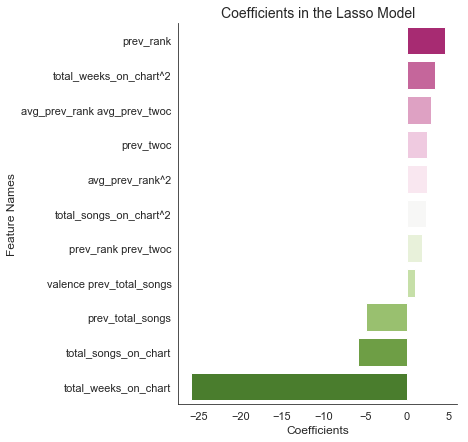

In [30]:
plt.rcParams['figure.figsize'] = (5.0, 7.0)
sns.barplot(x='coefficients', y='feature_names', data=imp_coef, palette='PiYG')
sns.despine()
sns.set_style('white')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel('Coefficients', fontsize=12)
plt.ylabel('Feature Names', fontsize=12)
plt.title("Coefficients in the Lasso Model", fontsize=14)
plt.savefig('Coefficients_lasso.png')

Text(0, 0.5, 'Residual')

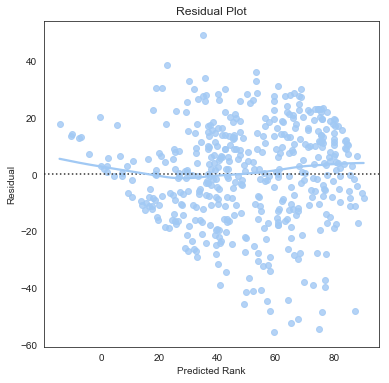

In [22]:
y_predict_test = lm_poly_lasso.predict(X_test_poly)
res = y_test - y_predict_test
# awkward line = cannot go below 0
sns.residplot(x=y_predict_test, y= res, lowess=True)
plt.figure(figsize=(6,6))
plt.title('Residual Plot')
plt.xlabel('Predicted Rank')
plt.ylabel('Residual')

In [24]:
new_predict = []
for i in y_predict_test:
    if i < 1:
        i = 1
    new_predict.append(i)

new_predict = np.array(new_predict)

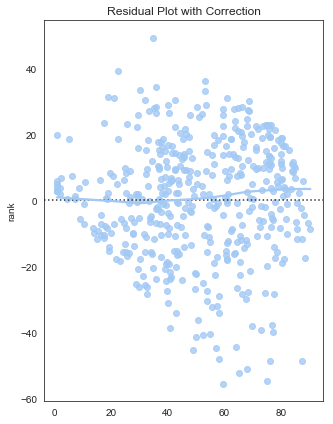

In [29]:
res_new = y_test - new_predict
# awkward line = cannot go below 0
plt.title('Residual Plot with Correction')
sns.residplot(x=new_predict, y= res_new, lowess=True)

Now that we have fixed our predictions, let's see what our final R<sup>2</sup>.

In [32]:
from sklearn.metrics import r2_score

In [33]:
r2_score(y_test, y_predict_test)

0.6162082983798769

Looks pretty good, let's see how our error is. I will be using Mean Absolute Error (MAE) to calculate my error. MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. As my prediction only has positive values and the magnitude of my errors is not as important, this makes the most sense for me to use. 

In [23]:
mae = mean_absolute_error(y_test, y_predict_test)
print(mae)

14.329723384697077


My MAE is around 14.3 meaning that my prediction model will be around 14.3 ranks off, which in comparison to my  R<sup>2</sup> is not super bad as my  R<sup>2</sup> suggests that my model will only be right around 62% of the time.